## 전처리

In [38]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("data/IMDB top 1000.csv")

# 상위 5개 행 미리보기
print(df.head())


   Unnamed: 0                                              Title Certificate  \
0           0                 1. The Shawshank Redemption (1994)           R   
1           1                            2. The Godfather (1972)           R   
2           2                          3. The Dark Knight (2008)       PG-13   
3           3                   4. The Godfather: Part II (1974)           R   
4           4  5. The Lord of the Rings: The Return of the Ki...       PG-13   

  Duration                     Genre  Rate  Metascore  \
0  142 min                     Drama   9.3       80.0   
1  175 min              Crime, Drama   9.2      100.0   
2  152 min      Action, Crime, Drama   9.0       84.0   
3  202 min              Crime, Drama   9.0       90.0   
4  201 min  Action, Adventure, Drama   8.9       94.0   

                                         Description  \
0  Two imprisoned men bond over a number of years...   
1  The aging patriarch of an organized crime dyna...   
2  When 

In [39]:
#  중복 제거
df = df.drop_duplicates(subset="Title", keep="first")

print("중복 제거 후 행 개수:", len(df))

#  결측치 제거
print("\n결측치 개수 확인:\n", df.isnull().sum())
df = df.dropna()
print("결측치 제거 후 크기:", df.shape)

#  필요한 컬럼만 선택
df = df[["Title", "Certificate", "Duration", "Genre", "Rate", "Metascore", "Info"]]

#  인덱스 리셋
df = df.reset_index(drop=True)

print("\n 전처리 완료!")
print(df.head())


중복 제거 후 행 개수: 398

결측치 개수 확인:
 Unnamed: 0       0
Title            0
Certificate      9
Duration         0
Genre            0
Rate             0
Metascore      112
Description      0
Cast             0
Info             0
dtype: int64
결측치 제거 후 크기: (286, 10)

 전처리 완료!
                                               Title Certificate Duration  \
0                 1. The Shawshank Redemption (1994)           R  142 min   
1                            2. The Godfather (1972)           R  175 min   
2                          3. The Dark Knight (2008)       PG-13  152 min   
3                   4. The Godfather: Part II (1974)           R  202 min   
4  5. The Lord of the Rings: The Return of the Ki...       PG-13  201 min   

                      Genre  Rate  Metascore  \
0                     Drama   9.3       80.0   
1              Crime, Drama   9.2      100.0   
2      Action, Crime, Drama   9.0       84.0   
3              Crime, Drama   9.0       90.0   
4  Action, Adventure, Drama   

In [40]:
import re

#  1. Duration → 숫자 변환
df["Duration"] = df["Duration"].str.replace(" min", "").astype(int)

#  2. Votes, Gross 컬럼 분리
def extract_votes(info):
    match = re.search(r"Votes:\s([\d,]+)", info)
    return int(match.group(1).replace(",", "")) if match else None

def extract_gross(info):
    match = re.search(r"Gross:\s\$(\d+\.\d+)M", info)
    return float(match.group(1)) if match else None

df["Votes"] = df["Info"].apply(extract_votes)
df["Gross(M)"] = df["Info"].apply(extract_gross)

#  3. 결측치 제거 (혹시 수익 데이터가 없는 경우 대비)
df = df.dropna(subset=["Votes", "Gross(M)"])

#  4. 필요없는 Info 제거
df = df.drop(columns=["Info"])

print(" 숫자형 변환 완료!\n")
print(df.info())
print("\n 샘플 미리보기:")
print(df.head(5))


 숫자형 변환 완료!

<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 0 to 285
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        262 non-null    object 
 1   Certificate  262 non-null    object 
 2   Duration     262 non-null    int64  
 3   Genre        262 non-null    object 
 4   Rate         262 non-null    float64
 5   Metascore    262 non-null    float64
 6   Votes        262 non-null    int64  
 7   Gross(M)     262 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 18.4+ KB
None

 샘플 미리보기:
                                               Title Certificate  Duration  \
0                 1. The Shawshank Redemption (1994)           R       142   
1                            2. The Godfather (1972)           R       175   
2                          3. The Dark Knight (2008)       PG-13       152   
3                   4. The Godfather: Part II (1974)           R       202   

In [41]:
import re

# Title에서 연도 추출
df["Year"] = df["Title"].str.extract(r"\((\d{4})\)").astype(int)

# 10년 단위로 묶기
df["Decade"] = (df["Year"] // 10) * 10

# decade 단위 정렬
df = df.sort_values("Decade")

print(df[["Title", "Year", "Decade"]].head(10))


                                        Title  Year  Decade
102                    127. Metropolis (1927)  1927    1920
48                     53. City Lights (1931)  1931    1930
224         315. It Happened One Night (1934)  1934    1930
47                    52. Modern Times (1936)  1936    1930
222  312. Mr. Smith Goes to Washington (1939)  1939    1930
223            313. Gone with the Wind (1939)  1939    1930
46                      51. Casablanca (1942)  1942    1940
219                 308. The Third Man (1949)  1949    1940
221                       311. Rebecca (1940)  1940    1940
100              124. Double Indemnity (1944)  1944    1940


In [42]:
decade_stats = df.groupby("Decade").agg({
    "Title": "count",       
    "Rate": "mean",
    "Metascore": "mean",
    "Gross(M)": "mean",
    "Duration": "mean",
    "Votes": "mean"
}).reset_index()

# 반올림
decade_stats = decade_stats.round(2)

# 컬럼명 정리
decade_stats.rename(columns={"Title": "Movie_Count"}, inplace=True)

print(decade_stats)



   Decade  Movie_Count  Rate  Metascore  Gross(M)  Duration      Votes
0    1920            1  8.30      98.00      1.24    153.00  157436.00
1    1930            5  8.26      90.40     42.56    129.20  172116.00
2    1940            7  8.23      96.00      2.62    110.86  209003.86
3    1950           15  8.28      93.13     15.00    129.60  237574.93
4    1960           12  8.33      88.75     17.62    144.58  311461.42
5    1970           15  8.39      86.20     82.07    132.93  657958.13
6    1980           23  8.25      81.65     74.47    131.57  497650.65
7    1990           52  8.29      78.94     84.73    125.31  710813.42
8    2000           67  8.20      79.76     94.61    130.13  620742.28
9    2010           65  8.16      79.65    137.02    129.71  517888.03


## 시각화

In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우 한글 폰트
mpl.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 깨짐 방지


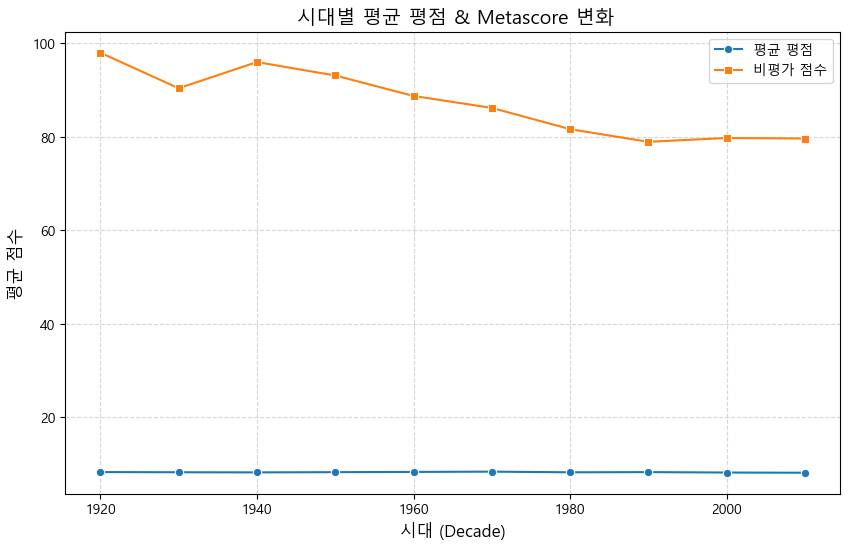

In [44]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=decade_stats, x="Decade", y="Rate", marker="o", label="평균 평점")
sns.lineplot(data=decade_stats, x="Decade", y="Metascore", marker="s", label="비평가 점수")

plt.title(" 시대별 평균 평점 & Metascore 변화", fontsize=14)
plt.xlabel("시대 (Decade)", fontsize=12)
plt.ylabel("평균 점수", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


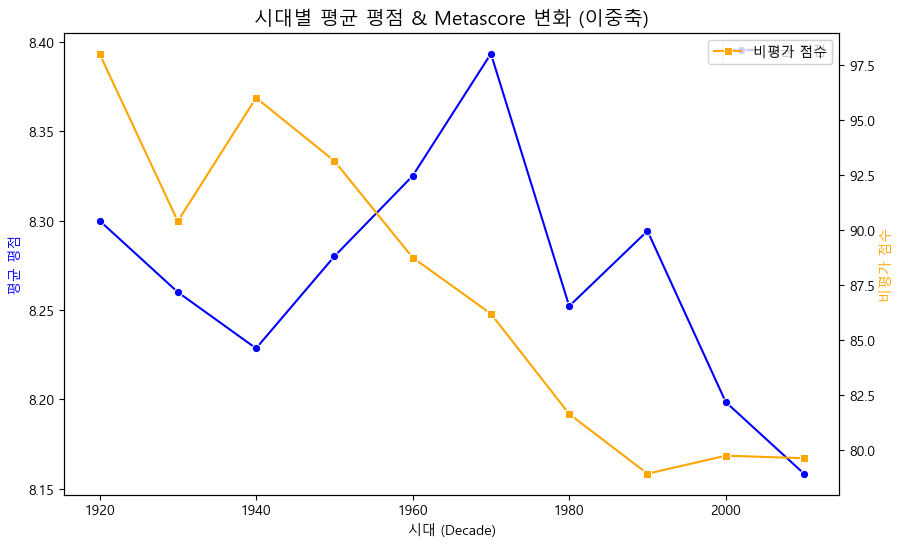

In [57]:
fig, ax1 = plt.subplots(figsize=(10,6))
sns.lineplot(data=decade_stats, x="Decade", y="Rate", marker="o", label="평균 평점", ax=ax1, color="b")
ax2 = ax1.twinx()
sns.lineplot(data=decade_stats, x="Decade", y="Metascore", marker="s", label="비평가 점수", ax=ax2, color="orange")
ax1.set_xlabel("시대 (Decade)")
ax1.set_ylabel("평균 평점", color="b")
ax2.set_ylabel("비평가 점수", color="orange")
plt.title("시대별 평균 평점 & Metascore 변화 (이중축)", fontsize=14)
plt.show()


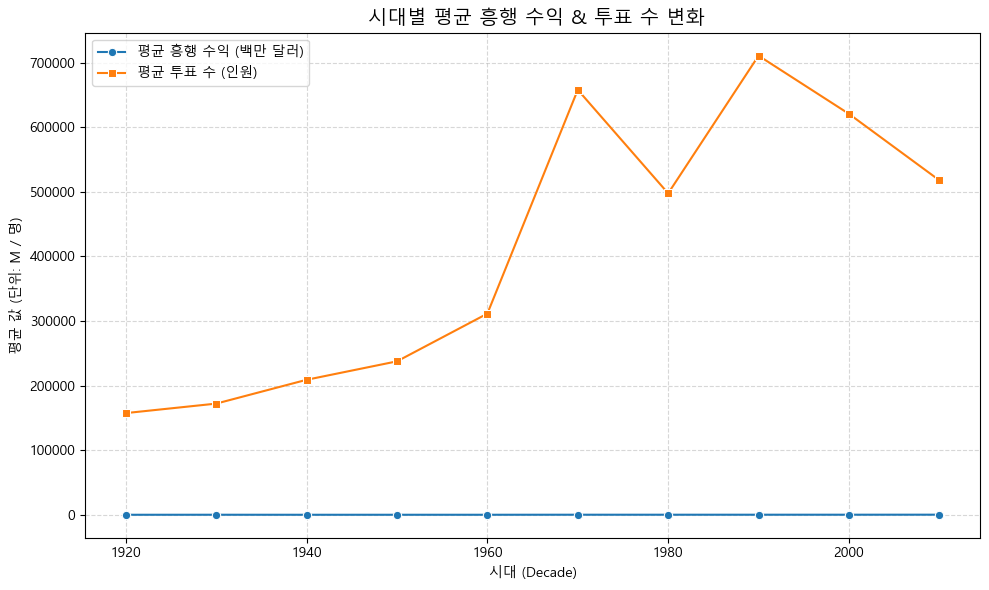

In [45]:
plt.figure(figsize=(10, 6))

# 평균 흥행 수익
sns.lineplot(data=decade_stats, x="Decade", y="Gross(M)", marker="o", label="평균 흥행 수익 (백만 달러)")

# 평균 투표 수
sns.lineplot(data=decade_stats, x="Decade", y="Votes", marker="s", label="평균 투표 수 (인원)")

plt.title(" 시대별 평균 흥행 수익 & 투표 수 변화", fontsize=14)
plt.xlabel("시대 (Decade)")
plt.ylabel("평균 값 (단위: M / 명)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [46]:
# 시대별 요약 테이블
decade_summary = df.groupby("Decade").agg(
    영화_편수=("Title", "count"),
    평균_평점=("Rate", "mean"),
    평균_메타스코어=("Metascore", "mean"),
    평균_수익=("Gross(M)", "mean"),
    중앙값_수익=("Gross(M)", "median")
).round(2)

print(decade_summary)


        영화_편수  평균_평점  평균_메타스코어   평균_수익  중앙값_수익
Decade                                        
1920        1   8.30     98.00    1.24    1.24
1930        5   8.26     90.40   42.56    4.36
1940        7   8.23     96.00    2.62    1.59
1950       15   8.28     93.13   15.00    4.36
1960       12   8.33     88.75   17.62   13.55
1970       15   8.39     86.20   82.07   57.30
1980       23   8.25     81.65   74.47   45.60
1990       52   8.29     78.94   84.73   44.64
2000       67   8.20     79.76   94.61   34.40
2010       65   8.16     79.65  137.02   67.21


In [47]:
print(df["Gross(M)"].describe())


count    262.000000
mean      88.792786
std      126.759412
min        0.010000
25%        4.515000
50%       33.050000
75%      131.970000
max      858.370000
Name: Gross(M), dtype: float64


평균에 비해 압도적으로 성과를 거둔 영화들 때문에 수익부분이 뭉개지는 것을 보완하기 위해 다시 재작업

In [48]:
decade_gross = df.groupby("Decade")["Gross(M)"].agg(["mean", "median", "count"]).round(2)
print(decade_gross)


          mean  median  count
Decade                       
1920      1.24    1.24      1
1930     42.56    4.36      5
1940      2.62    1.59      7
1950     15.00    4.36     15
1960     17.62   13.55     12
1970     82.07   57.30     15
1980     74.47   45.60     23
1990     84.73   44.64     52
2000     94.61   34.40     67
2010    137.02   67.21     65


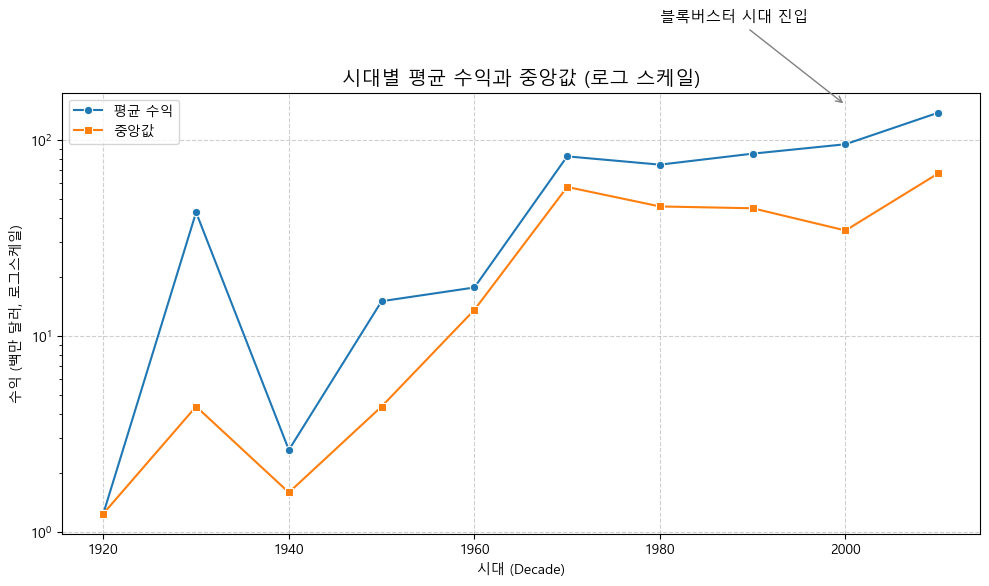

In [49]:
plt.figure(figsize=(10,6))
sns.lineplot(data=decade_gross, x=decade_gross.index, y="mean", marker="o", label="평균 수익")
sns.lineplot(data=decade_gross, x=decade_gross.index, y="median", marker="s", label="중앙값")
plt.yscale("log")
plt.title("시대별 평균 수익과 중앙값 (로그 스케일)", fontsize=14)
plt.xlabel("시대 (Decade)")
plt.ylabel("수익 (백만 달러, 로그스케일)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# 산업 급상승 구간 강조 (예: 2000년대)
plt.annotate("블록버스터 시대 진입", xy=(2000, 150), xytext=(1980, 400),
             arrowprops=dict(arrowstyle="->", color="gray"), fontsize=11)

plt.tight_layout()
plt.show()



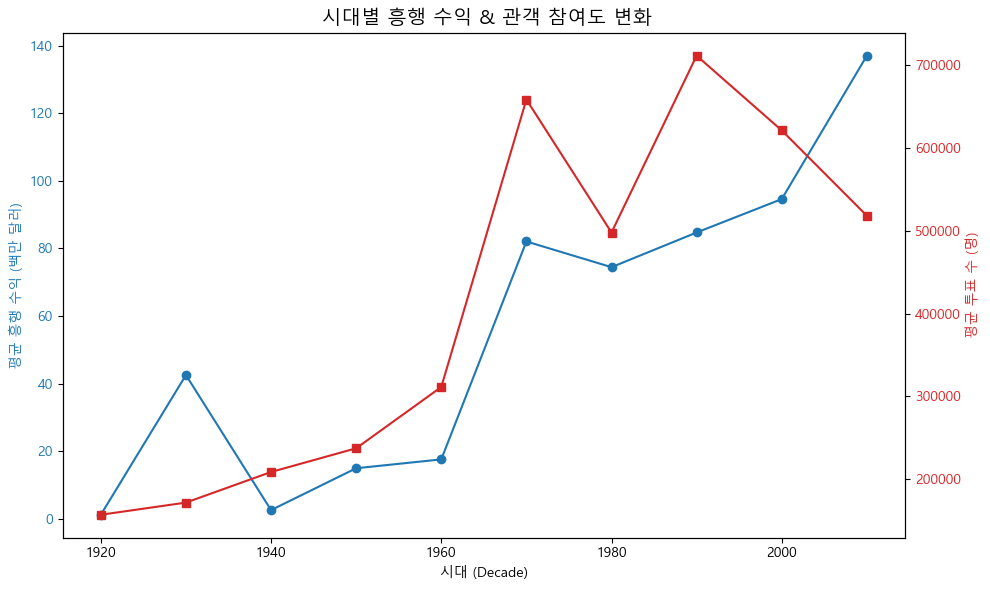

In [50]:
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = "tab:blue"
ax1.set_xlabel("시대 (Decade)")
ax1.set_ylabel("평균 흥행 수익 (백만 달러)", color=color1)
ax1.plot(decade_stats["Decade"], decade_stats["Gross(M)"], color=color1, marker="o", label="평균 흥행 수익")
ax1.tick_params(axis="y", labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:red"
ax2.set_ylabel("평균 투표 수 (명)", color=color2)
ax2.plot(decade_stats["Decade"], decade_stats["Votes"], color=color2, marker="s", label="평균 투표 수")
ax2.tick_params(axis="y", labelcolor=color2)

plt.title(" 시대별 흥행 수익 & 관객 참여도 변화", fontsize=14)
fig.tight_layout()
plt.show()


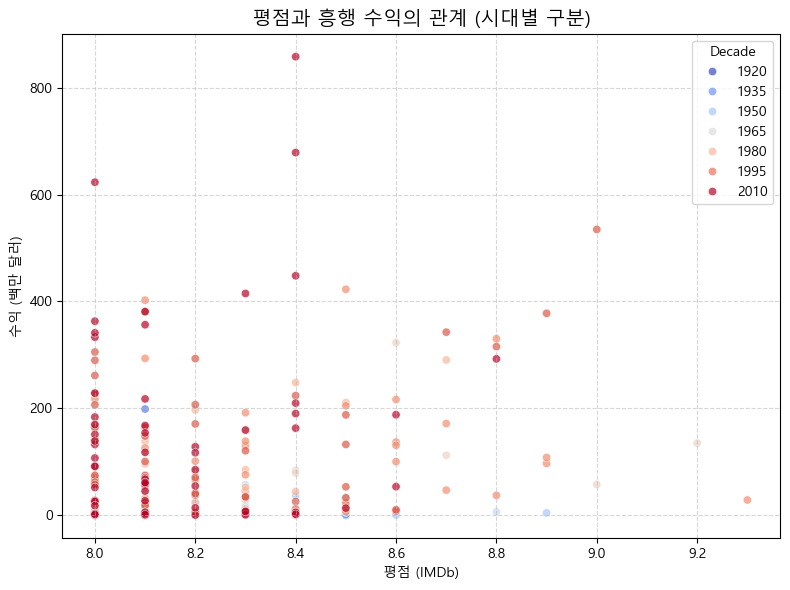

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Rate", y="Gross(M)", hue="Decade", alpha=0.7, palette="coolwarm")
plt.title("평점과 흥행 수익의 관계 (시대별 구분)", fontsize=14)
plt.xlabel("평점 (IMDb)")
plt.ylabel("수익 (백만 달러)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
